In [2]:
# 模組
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
#import plotly.graph_objects as go
#import plotly.express as px
#from plotly.subplots import make_subplots

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
#from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, r2_score
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import OneHotEncoder

In [3]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.shape

(5110, 12)

In [5]:
# Checking Information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
# Checking for duplicates in the dataset

display("Total number of of Duplicates present in data: %s" %data.duplicated().sum())

'Total number of of Duplicates present in data: 0'

### Data Preprocessing

In [7]:
# Removing id column as it is not of much importance
data.drop("id", inplace=True, axis=1)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [8]:
data = data.drop(data[data['gender'] == 'Other'].index)

In [9]:
# Dropping the unusual category 
data =  data.drop(data[data['smoking_status']=='Unknown'].index)
data.shape

(3565, 11)

In [10]:
data['smoking_status'].value_counts()

never smoked       1892
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [11]:
# Checking for missing values in the dataset
print("Number of Missing Values in our data set\n")
missing_data = data.isnull().sum().to_frame().reset_index().rename({"index" : 'Variable', 0: 'Missing Values'}, axis =1)
display(missing_data.style.background_gradient('gnuplot2_r'))

Number of Missing Values in our data set



,Variable,Missing Values
0,gender,0
1,age,0
2,hypertension,0
3,heart_disease,0
4,ever_married,0
5,work_type,0
6,Residence_type,0
7,avg_glucose_level,0
8,bmi,140
9,smoking_status,0


In [12]:
# fill up missing values in Numerical Continuous columns
data['bmi'].fillna(data['bmi'].mean(), inplace = True)
display(data.isnull().sum().to_frame().reset_index().rename({'index' : 'Variables', 0: 'Missing Values'}, axis =1).style.background_gradient('copper_r'))

,Variables,Missing Values
0,gender,0
1,age,0
2,hypertension,0
3,heart_disease,0
4,ever_married,0
5,work_type,0
6,Residence_type,0
7,avg_glucose_level,0
8,bmi,0
9,smoking_status,0


### Data Description and Initial Cleaning

In [13]:
# Checking Statistics Summary of numerical columns
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000
mean,48.860309,0.125105,0.063955,108.972376,30.292350,0.056662
std,18.873140,0.330885,0.244707,48.295550,7.151047,0.231228
min,10.000000,0.000000,0.000000,55.120000,11.500000,0.000000
25%,34.000000,0.000000,0.000000,77.460000,25.400000,0.000000
50%,50.000000,0.000000,0.000000,92.650000,29.400000,0.000000
75%,63.000000,0.000000,0.000000,116.670000,33.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In [14]:
# Checking Summary of categorical columns
data.describe(include="object")

,gender,ever_married,work_type,Residence_type,smoking_status
count,3565,3565,3565,3565,3565
unique,2,2,5,2,3
top,Female,Yes,Private,Urban,never smoked
freq,2158,2710,2284,1814,1892


### Handling Categorical Data

In [15]:
# Making List of Categorical Columns

categorical = list(data.dtypes[data.dtypes == 'object'].index)
categorical

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [16]:
#Cleaning Categorical Data in our data set
# 主要處理的是 smoking_status

for col in categorical:
    data[col] = data[col].str.lower().str.replace(" ", "_")
    
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,male,67.0,0,1,yes,private,urban,228.69,36.60000,formerly_smoked,1
1,female,61.0,0,0,yes,self-employed,rural,202.21,30.29235,never_smoked,1
2,male,80.0,0,1,yes,private,rural,105.92,32.50000,never_smoked,1
3,female,49.0,0,0,yes,private,urban,171.23,34.40000,smokes,1
4,female,79.0,1,0,yes,self-employed,rural,174.12,24.00000,never_smoked,1


In [17]:
# Resetting the index after removing the unusual category
data.reset_index(drop=True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,male,67.0,0,1,yes,private,urban,228.69,36.60000,formerly_smoked,1
1,female,61.0,0,0,yes,self-employed,rural,202.21,30.29235,never_smoked,1
2,male,80.0,0,1,yes,private,rural,105.92,32.50000,never_smoked,1
3,female,49.0,0,0,yes,private,urban,171.23,34.40000,smokes,1
4,female,79.0,1,0,yes,self-employed,rural,174.12,24.00000,never_smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
3560,female,57.0,0,0,yes,private,rural,77.93,21.70000,never_smoked,0
3561,female,80.0,1,0,yes,private,urban,83.75,30.29235,never_smoked,0
3562,female,81.0,0,0,yes,self-employed,urban,125.20,40.00000,never_smoked,0
3563,female,35.0,0,0,yes,self-employed,rural,82.99,30.60000,never_smoked,0


### Visualization

C:\Users\angus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

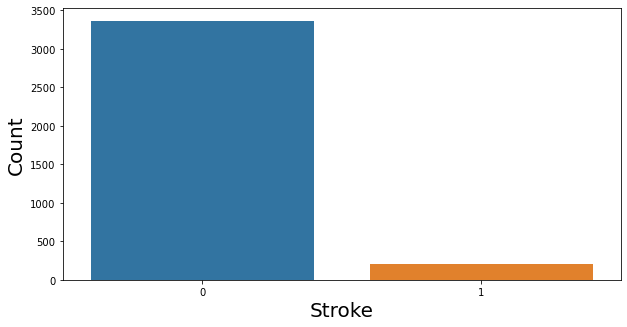

In [18]:
stroke_label = data.stroke.value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(stroke_label.index, stroke_label)
plt.xlabel('Stroke', fontsize=20)
plt.ylabel('Count', fontsize=20)

In [19]:
data['stroke'].value_counts()

0    3363
1     202
Name: stroke, dtype: int64

In [20]:
data[['age','avg_glucose_level','bmi']].describe()

,age,avg_glucose_level,bmi
count,3565.000000,3565.000000,3565.000000
mean,48.860309,108.972376,30.292350
std,18.873140,48.295550,7.151047
min,10.000000,55.120000,11.500000
25%,34.000000,77.460000,25.400000
50%,50.000000,92.650000,29.400000
75%,63.000000,116.670000,33.800000
max,82.000000,271.740000,92.000000


Text(0.5, 1.0, 'Boxplot')

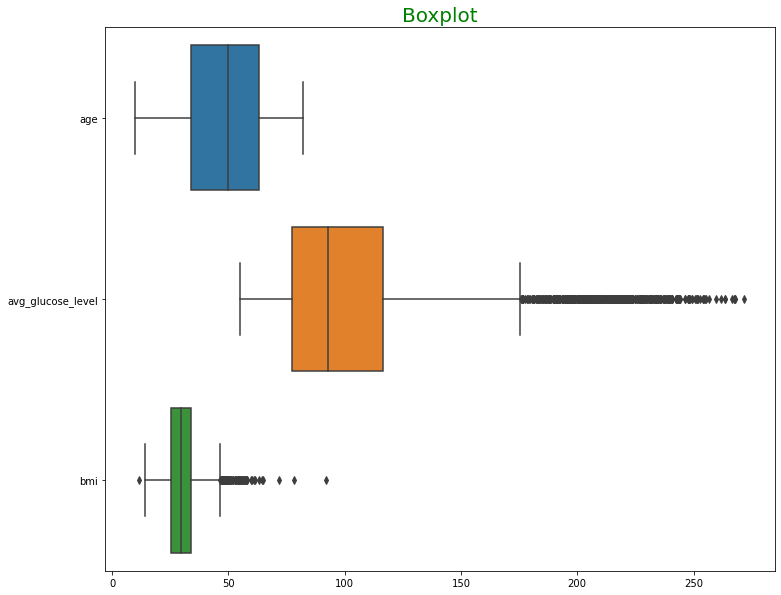

In [21]:
fig, axes = plt.subplots(figsize=(12, 10)) # 設定畫布大小
sns.boxplot(data=data[['age','avg_glucose_level','bmi']], orient="h", ax=axes) # 繪圖
axes.set_title("Boxplot", fontsize = 20, color = 'green') # 標題

In [22]:
df_sta = data

In [23]:
df_sta.work_type.value_counts()

private          2284
self-employed     663
govt_job          535
children           69
never_worked       14
Name: work_type, dtype: int64

### Sample

In [24]:
from sklearn.utils import resample

# Separate Target Classes
df_1 = data[data.stroke==0]
df_2 = data[data.stroke==1]
 
# Upsample minority class
df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=250)    # to match majority class

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_2, df_1_upsampled])
 
# Display new class counts
df_upsampled.stroke.value_counts()

0    250
1    202
Name: stroke, dtype: int64

In [25]:
# df_upsampled.to_csv('df_upsampled.csv')

In [ ]:
# df_upsampled = pd.read_csv("df_upsampled.csv")
# df_upsampled.head()

C:\Users\angus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count')

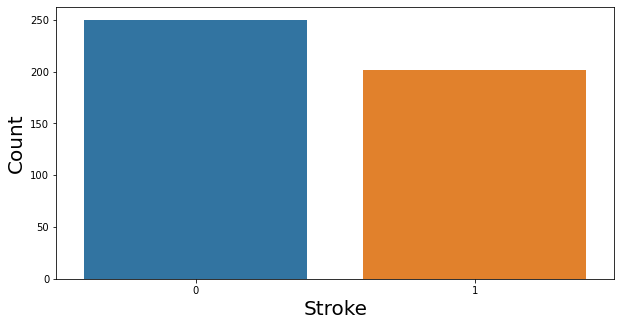

In [25]:
stroke_label = df_upsampled.stroke.value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(stroke_label.index, stroke_label)
plt.xlabel('Stroke', fontsize=20)
plt.ylabel('Count', fontsize=20)

Text(0.5, 1.0, 'Boxplot')

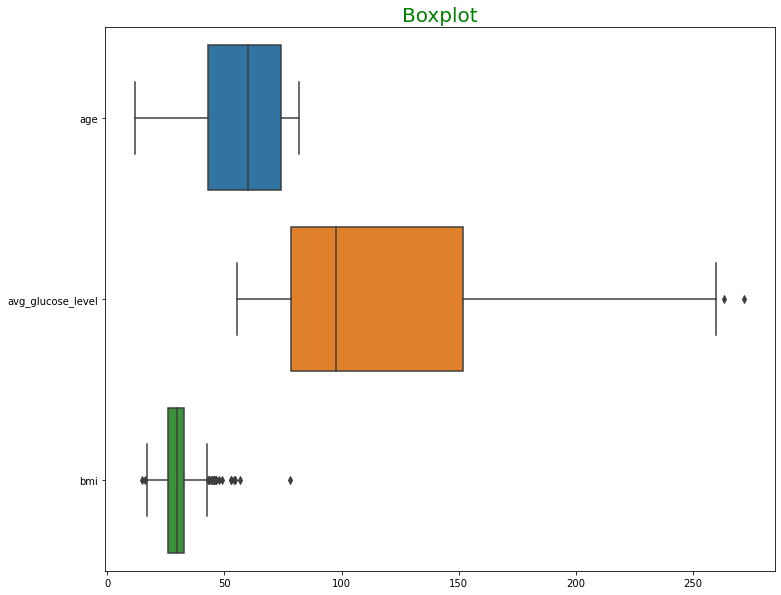

In [26]:
fig, axes = plt.subplots(figsize=(12, 10)) # 設定畫布大小
sns.boxplot(data=df_upsampled[['age','avg_glucose_level','bmi']], orient="h", ax=axes) # 繪圖
axes.set_title("Boxplot", fontsize = 20, color = 'green') # 標題

In [27]:
df_upsampled[['age','avg_glucose_level','bmi']].describe()

,age,avg_glucose_level,bmi
count,452.000000,452.000000,452.000000
mean,57.274336,120.418252,30.188822
std,19.113037,56.381095,6.666309
min,12.000000,55.340000,15.000000
25%,43.000000,78.300000,26.075000
50%,60.000000,97.580000,29.800000
75%,74.000000,151.740000,32.725000
max,82.000000,271.740000,78.000000


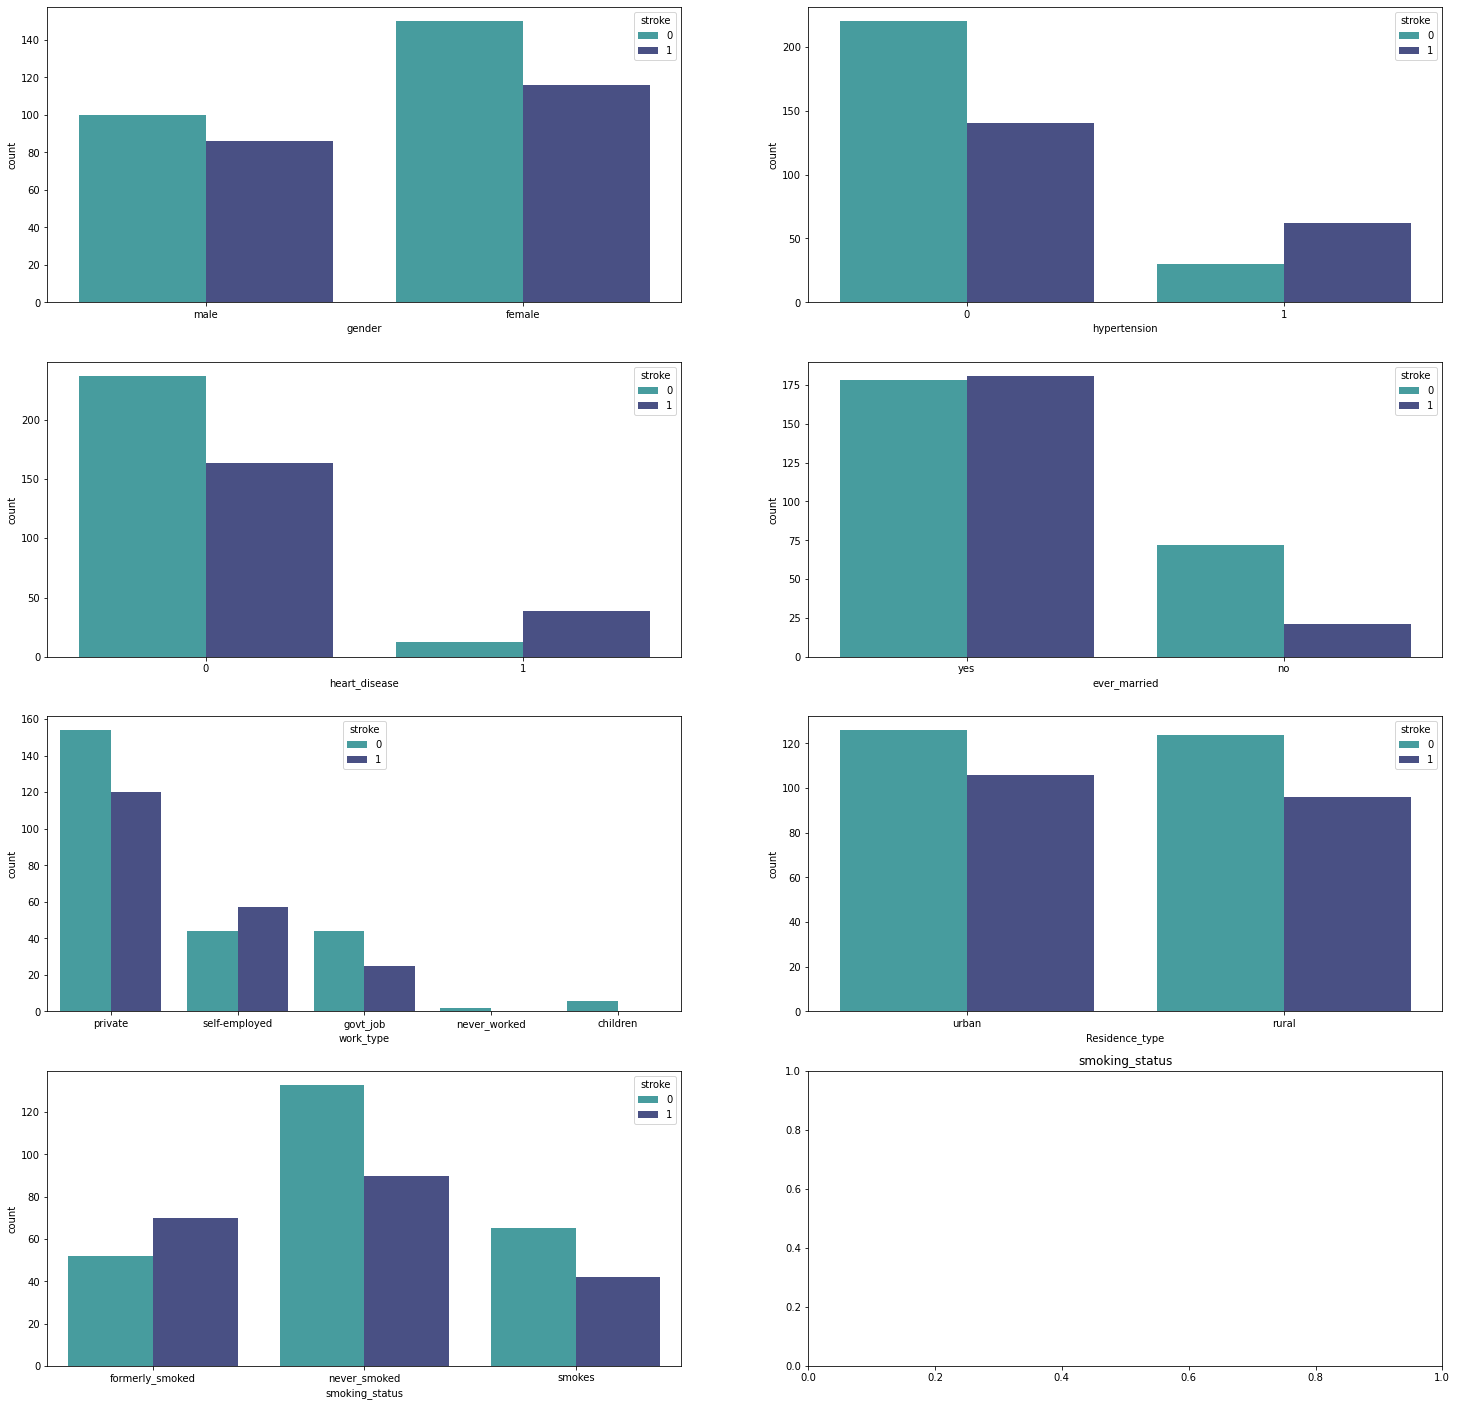

In [30]:
df_st=['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']
fig, axs = plt.subplots(4, 2, figsize=(25,25))
axs = axs.flatten()
for i, col_name in enumerate(df_st):
     
     sns.countplot(x=col_name, data=df_upsampled, ax=axs[i], hue =df_upsampled['stroke'],palette='mako_r')
     #ax.set_title(col_name, fontdict={'fontsize': 12},fontweight ='bold')
     plt.title(col_name)

In [32]:
# one hot encoding all the categories data and getting final dataset
final=pd.get_dummies(df_upsampled, columns=['gender','ever_married','Residence_type','work_type','smoking_status'])
final

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_female,gender_male,ever_married_no,ever_married_yes,Residence_type_rural,Residence_type_urban,work_type_children,work_type_govt_job,work_type_never_worked,work_type_private,work_type_self-employed,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,30.29235,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0
2,80.0,0,1,105.92,32.50000,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0
3,49.0,0,0,171.23,34.40000,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.00000,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,38.0,0,0,133.62,25.20000,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0
4000,24.0,0,0,105.26,26.10000,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0
4399,23.0,0,0,84.93,24.20000,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0
2657,36.0,0,0,129.43,29.70000,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0


In [31]:
final.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke', 'gender_female', 'gender_male', 'ever_married_no',
       'ever_married_yes', 'Residence_type_rural', 'Residence_type_urban',
       'work_type_children', 'work_type_govt_job', 'work_type_never_worked',
       'work_type_private', 'work_type_self-employed',
       'smoking_status_formerly_smoked', 'smoking_status_never_smoked',
       'smoking_status_smokes'],
      dtype='object')

In [32]:
data1 = final[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_male', 
       'ever_married_yes',  'Residence_type_urban',
       'work_type_children', 'work_type_govt_job', 'work_type_never_worked',
       'work_type_private', 'work_type_self-employed',
       'smoking_status_formerly_smoked', 'smoking_status_never_smoked',
       'smoking_status_smokes','stroke']]

Text(0.5, 1.0, 'Correlation Matrix')

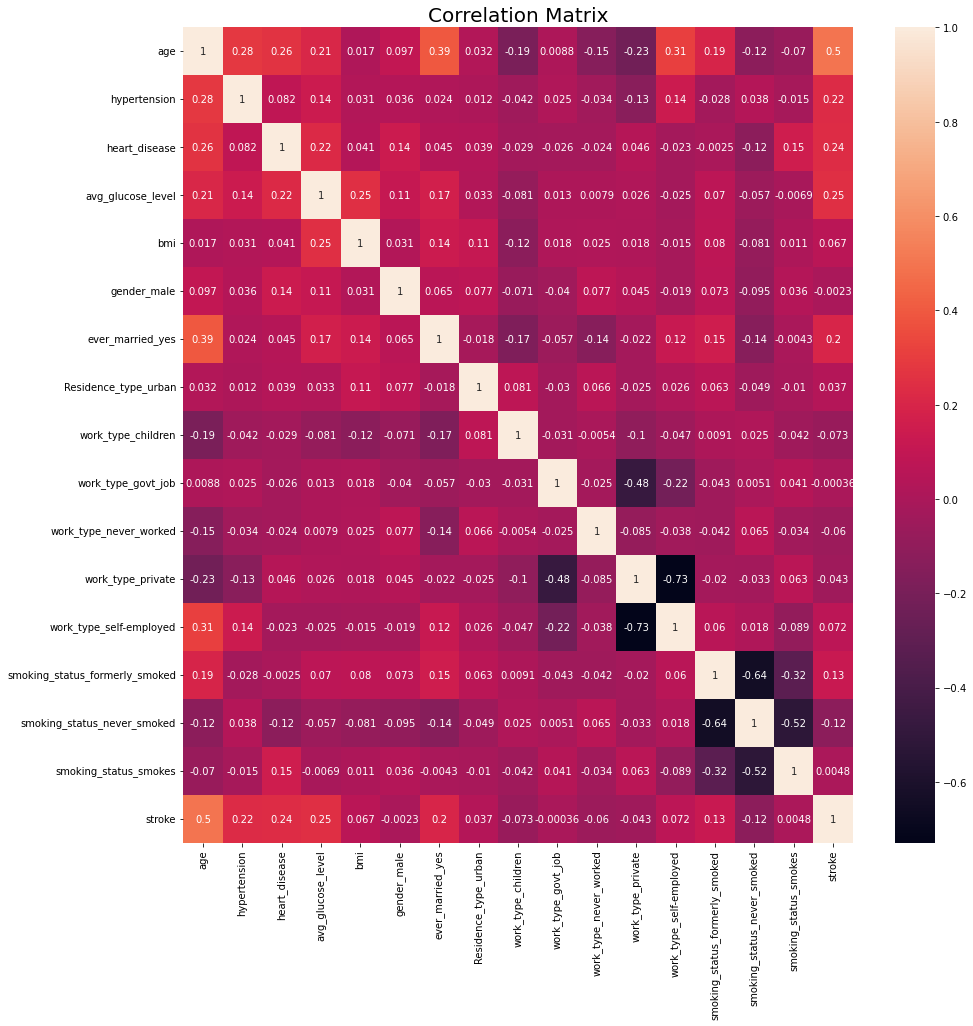

In [33]:
#Correlation of all features after label encoding
plt.figure(figsize=(15, 15))
sns.heatmap(data1.corr(), annot=True)
plt.title('Correlation Matrix', fontsize=20)

In [34]:
#Sorting feature according to their importance
data1.corr()['stroke'].sort_values(ascending = False)[1:]

age                               0.495495
avg_glucose_level                 0.248903
heart_disease                     0.236285
hypertension                      0.224980
ever_married_yes                  0.197647
smoking_status_formerly_smoked    0.126388
work_type_self-employed           0.071604
bmi                               0.067300
Residence_type_urban              0.036546
smoking_status_smokes             0.004822
work_type_govt_job               -0.000359
gender_male                      -0.002269
work_type_private                -0.042900
work_type_never_worked           -0.059926
work_type_children               -0.073476
smoking_status_never_smoked      -0.117814
Name: stroke, dtype: float64

### DT

In [35]:
X = data1[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_male', 
       'ever_married_yes',  'Residence_type_urban',
       'work_type_children', 'work_type_govt_job', 'work_type_never_worked',
       'work_type_private', 'work_type_self-employed',
       'smoking_status_formerly_smoked', 'smoking_status_never_smoked',
       'smoking_status_smokes']]
y = data1[['stroke']]

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

[[40 10]
 [18 23]]
Train Accuracy: 1.000
Test Accuracy: 0.692


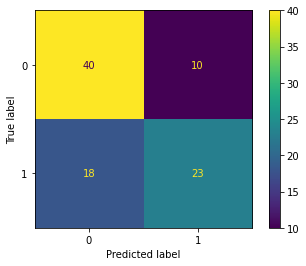

[0.56521739 0.63043478 0.64444444 0.6        0.68888889 0.75555556
 0.6        0.62222222 0.57777778 0.64444444]
k-fold Accuracy: 0.633
k-fold Standard Deviation: 0.053
recall_score: 0.561 
precision_score: 0.697 
f1_score: 0.622 


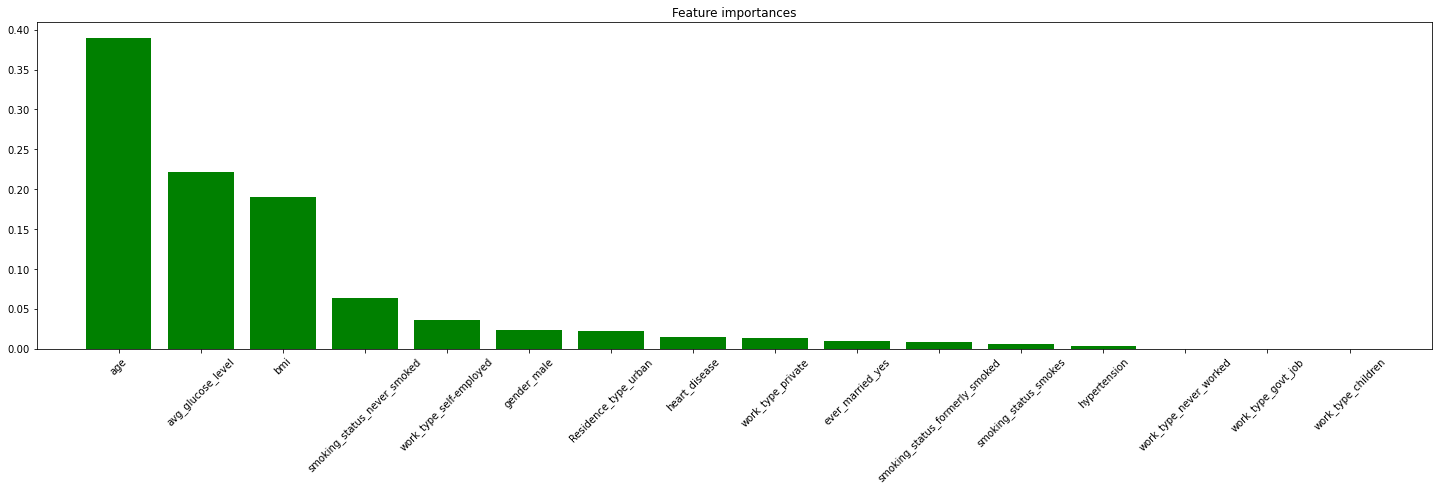

age - 0.390
avg_glucose_level - 0.222
bmi - 0.191
smoking_status_never_smoked - 0.063
work_type_self-employed - 0.036
gender_male - 0.023
Residence_type_urban - 0.022
heart_disease - 0.015
work_type_private - 0.013
ever_married_yes - 0.009
smoking_status_formerly_smoked - 0.008
smoking_status_smokes - 0.006
hypertension - 0.004
work_type_never_worked - 0.000
work_type_govt_job - 0.000
work_type_children - 0.000


In [37]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Making the Confusion Martix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
pred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print (cm)
print("Train Accuracy: {:.3f}".format(accuracy_score(y_train,pred_train)))
print("Test Accuracy: {:.3f}".format(accuracy_score(y_test,y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Applying k-fold Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
accuracies = cross_val_score(estimator = classifier ,X = sc.fit_transform(X),y = y,cv = 10)
print(accuracies)
print("k-fold Accuracy: {:.3f}".format(accuracies.mean()))
print("k-fold Standard Deviation: {:.3f}".format(accuracies.std()))

#其他模型評估指標
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
Sens = recall_score(y_test, y_pred)
Prec = precision_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred) 
print("recall_score: {:.3f} ".format(Sens))
print("precision_score: {:.3f} ".format(Prec))
print("f1_score: {:.3f} ".format(F1))

#特徵重要度
features = X.columns
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

#將特徵重要度以柱狀圖展示
plt.figure(figsize = (25, 6))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()


#輸出各個特徵的重要度
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

### feature select (importances = 0)

In [53]:
X2 = data1[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_male', 'ever_married_yes',  'Residence_type_urban',
       'work_type_govt_job', 'work_type_private', 'work_type_self-employed',
       'smoking_status_formerly_smoked', 'smoking_status_never_smoked',
       'smoking_status_smokes']]
y2 = data1[['stroke']]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.2, random_state = 0)

[[36 14]
 [14 27]]
Train Accuracy: 1.000
Test Accuracy: 0.692


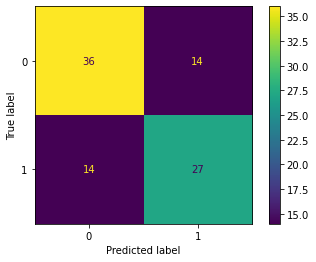

[0.65217391 0.54347826 0.8        0.53333333 0.57777778 0.6
 0.77777778 0.71111111 0.73333333 0.68888889]
k-fold Accuracy: 0.662
k-fold Standard Deviation: 0.091
recall_score: 0.659 
precision_score: 0.659 
f1_score: 0.659 


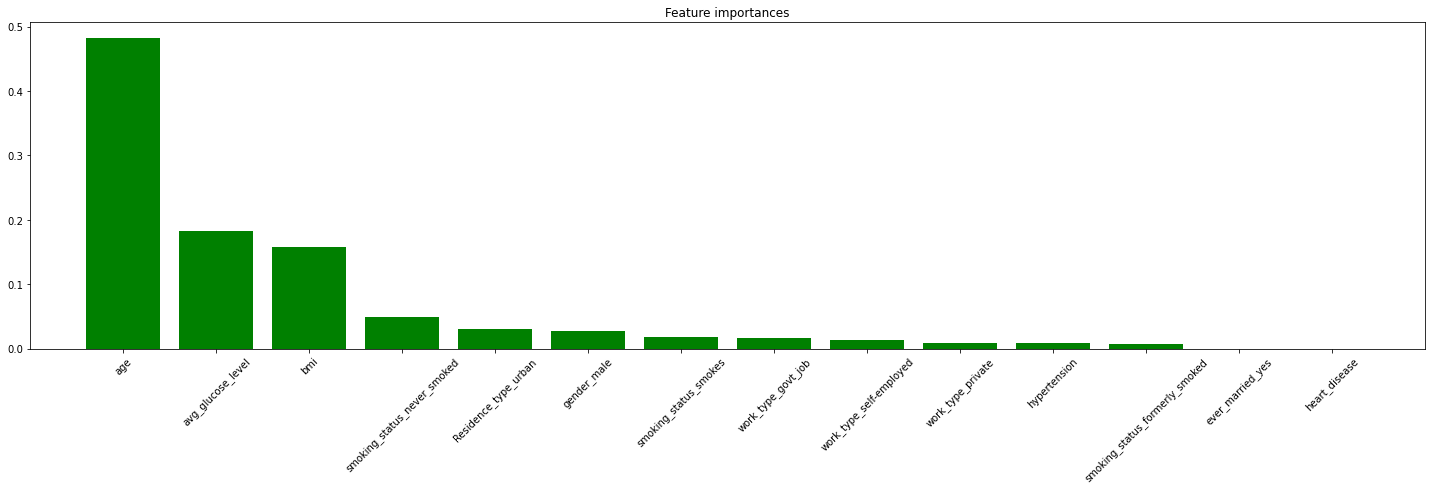

age - 0.482
avg_glucose_level - 0.182
bmi - 0.158
smoking_status_never_smoked - 0.048
Residence_type_urban - 0.030
gender_male - 0.027
smoking_status_smokes - 0.018
work_type_govt_job - 0.016
work_type_self-employed - 0.013
work_type_private - 0.009
hypertension - 0.008
smoking_status_formerly_smoked - 0.008
ever_married_yes - 0.000
heart_disease - 0.000


In [55]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Making the Confusion Martix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
pred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print (cm)
print("Train Accuracy: {:.3f}".format(accuracy_score(y_train,pred_train)))
print("Test Accuracy: {:.3f}".format(accuracy_score(y_test,y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Applying k-fold Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
accuracies = cross_val_score(estimator = classifier ,X = sc.fit_transform(X2),y = y2,cv = 10)
print(accuracies)
print("k-fold Accuracy: {:.3f}".format(accuracies.mean()))
print("k-fold Standard Deviation: {:.3f}".format(accuracies.std()))

#其他模型評估指標
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
Sens = recall_score(y_test, y_pred)
Prec = precision_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred) 
print("recall_score: {:.3f} ".format(Sens))
print("precision_score: {:.3f} ".format(Prec))
print("f1_score: {:.3f} ".format(F1))

#特徵重要度
features = X2.columns
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

#將特徵重要度以柱狀圖展示
plt.figure(figsize = (25, 6))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()


#輸出各個特徵的重要度
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

### feature select (coef)

In [56]:
X3 = data1[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_male', 'ever_married_yes', 'work_type_self-employed',
       'smoking_status_formerly_smoked']]
y3 = data1[['stroke']]

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size = 0.2, random_state = 0)

[[37 13]
 [13 28]]
Train Accuracy: 1.000
Test Accuracy: 0.714


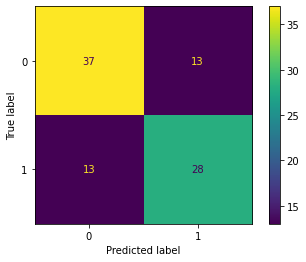

[0.7173913  0.63043478 0.77777778 0.57777778 0.66666667 0.6
 0.73333333 0.68888889 0.75555556 0.57777778]
k-fold Accuracy: 0.673
k-fold Standard Deviation: 0.070
recall_score: 0.683 
precision_score: 0.683 
f1_score: 0.683 


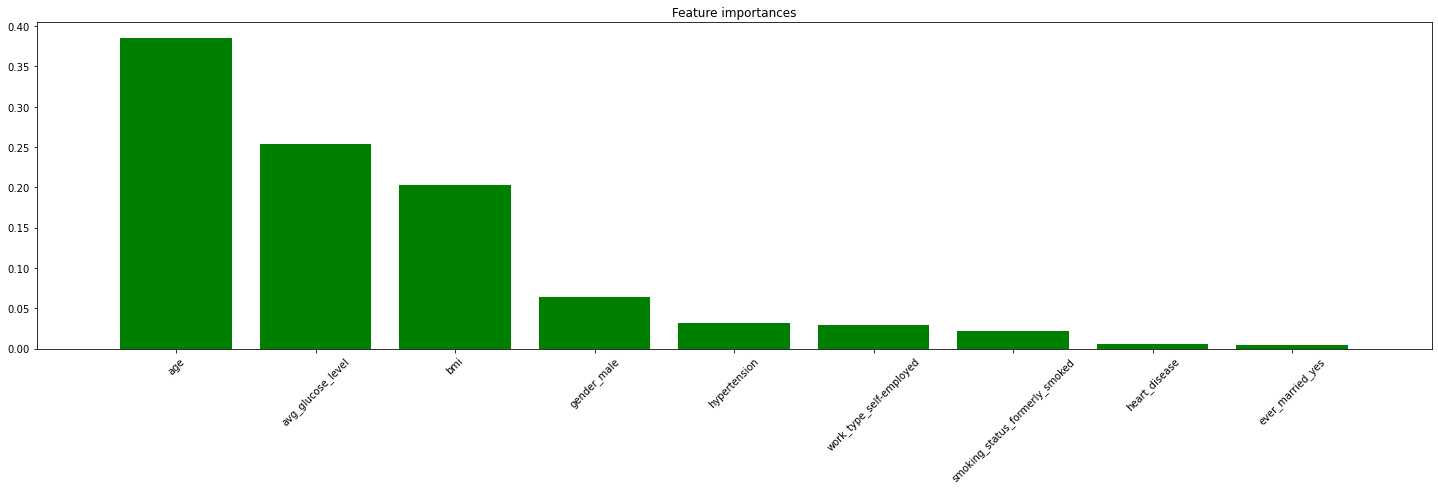

age - 0.385
avg_glucose_level - 0.254
bmi - 0.203
gender_male - 0.064
hypertension - 0.032
work_type_self-employed - 0.029
smoking_status_formerly_smoked - 0.022
heart_disease - 0.006
ever_married_yes - 0.004


In [58]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Making the Confusion Martix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
pred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print (cm)
print("Train Accuracy: {:.3f}".format(accuracy_score(y_train,pred_train)))
print("Test Accuracy: {:.3f}".format(accuracy_score(y_test,y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Applying k-fold Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
accuracies = cross_val_score(estimator = classifier ,X = sc.fit_transform(X3),y = y3,cv = 10)
print(accuracies)
print("k-fold Accuracy: {:.3f}".format(accuracies.mean()))
print("k-fold Standard Deviation: {:.3f}".format(accuracies.std()))

#其他模型評估指標
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
Sens = recall_score(y_test, y_pred)
Prec = precision_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred) 
print("recall_score: {:.3f} ".format(Sens))
print("precision_score: {:.3f} ".format(Prec))
print("f1_score: {:.3f} ".format(F1))

#特徵重要度
features = X3.columns
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

#將特徵重要度以柱狀圖展示
plt.figure(figsize = (25, 6))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()


#輸出各個特徵的重要度
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

### feature select (age/hypertension/heart/glucose/bmi/gender/smoke)

In [59]:
X1 = data1[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_male','smoking_status_formerly_smoked',
       'smoking_status_never_smoked', 'smoking_status_smokes']]
y1 = data1[["stroke"]]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state = 0)

[[38 12]
 [15 26]]
Train Accuracy: 1.000
Test Accuracy: 0.703


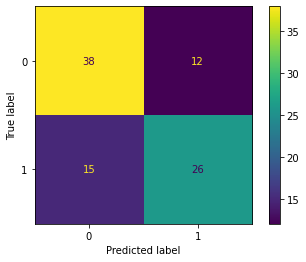

[0.7173913  0.63043478 0.77777778 0.57777778 0.66666667 0.6
 0.73333333 0.68888889 0.75555556 0.57777778]
k-fold Accuracy: 0.673
k-fold Standard Deviation: 0.070
recall_score: 0.634 
precision_score: 0.684 
f1_score: 0.658 


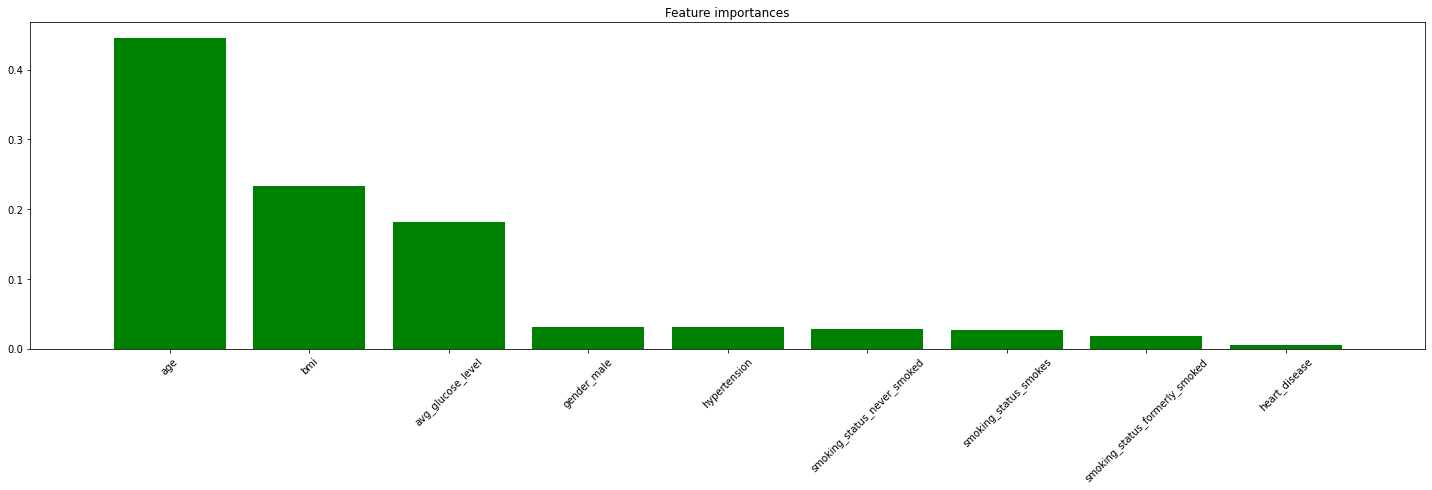

age - 0.445
bmi - 0.233
avg_glucose_level - 0.181
gender_male - 0.031
hypertension - 0.030
smoking_status_never_smoked - 0.028
smoking_status_smokes - 0.027
smoking_status_formerly_smoked - 0.018
heart_disease - 0.006


In [61]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Making the Confusion Martix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
pred_train = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print (cm)
print("Train Accuracy: {:.3f}".format(accuracy_score(y_train,pred_train)))
print("Test Accuracy: {:.3f}".format(accuracy_score(y_test,y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Applying k-fold Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
accuracies = cross_val_score(estimator = classifier ,X = sc.fit_transform(X3),y = y3,cv = 10)
print(accuracies)
print("k-fold Accuracy: {:.3f}".format(accuracies.mean()))
print("k-fold Standard Deviation: {:.3f}".format(accuracies.std()))

#其他模型評估指標
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
Sens = recall_score(y_test, y_pred)
Prec = precision_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred) 
print("recall_score: {:.3f} ".format(Sens))
print("precision_score: {:.3f} ".format(Prec))
print("f1_score: {:.3f} ".format(F1))

#特徵重要度
features = X1.columns
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

#將特徵重要度以柱狀圖展示
plt.figure(figsize = (25, 6))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()


#輸出各個特徵的重要度
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))

# Randomforest

In [42]:
dummy_data = pd.get_dummies(data, columns=['gender','ever_married','Residence_type','work_type','smoking_status'])
dummy_data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_female,gender_male,ever_married_no,ever_married_yes,Residence_type_rural,Residence_type_urban,work_type_children,work_type_govt_job,work_type_never_worked,work_type_private,work_type_self-employed,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.60000,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,30.29235,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0
2,80.0,0,1,105.92,32.50000,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0
3,49.0,0,0,171.23,34.40000,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.00000,1,1,0,0,1,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5102,57.0,0,0,77.93,21.70000,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0
5105,80.0,1,0,83.75,30.29235,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0
5106,81.0,0,0,125.20,40.00000,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0
5107,35.0,0,0,82.99,30.60000,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0


In [43]:
X5 = dummy_data[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'gender_male', 'ever_married_yes', 'work_type_self-employed',
       'smoking_status_formerly_smoked']]
y5 = dummy_data[['stroke']]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size = 0.2, random_state = 0)

/var/folders/3h/5vdwjvys3nl14_5ds2d_rzjm0000gn/T/ipykernel_15625/3499629125.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


[[674   0]
 [ 39   0]]
Train Accuracy: 1.000
Test Accuracy: 0.945


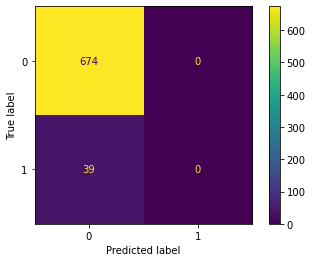

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y wa

[0.93837535 0.93837535 0.94117647 0.94397759 0.94117647 0.94101124
 0.94662921 0.94382022 0.94382022 0.94101124]
k-fold Accuracy: 0.942
k-fold Standard Deviation: 0.002
recall_score: 0.000 
precision_score: 0.000 
f1_score: 0.000 


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


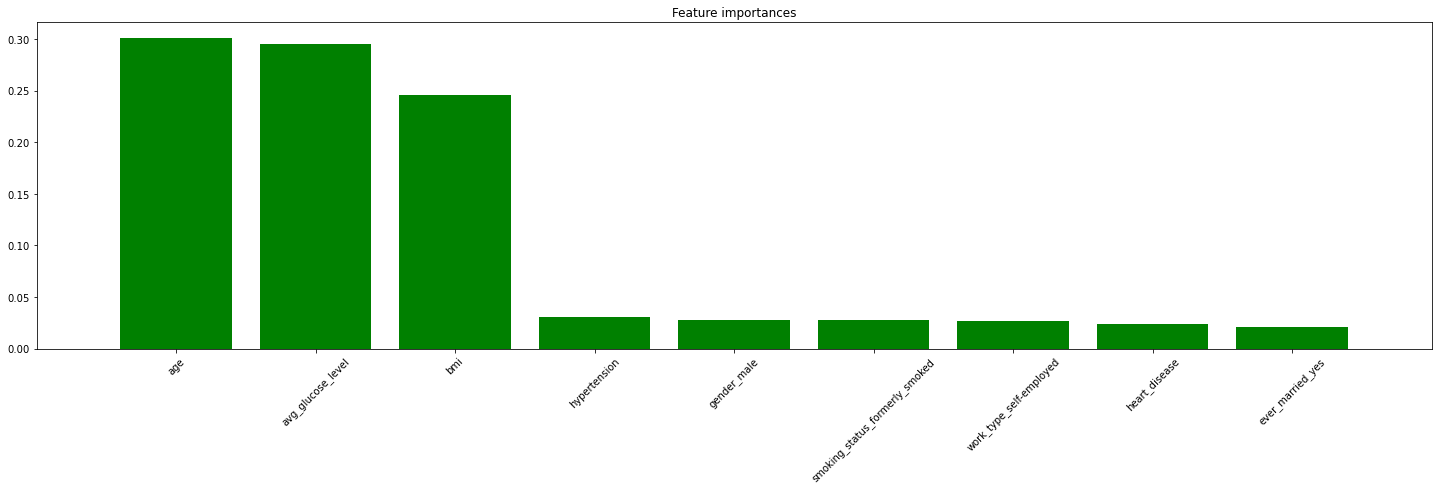

age - 0.301
avg_glucose_level - 0.295
bmi - 0.246
hypertension - 0.031
gender_male - 0.028
smoking_status_formerly_smoked - 0.028
work_type_self-employed - 0.027
heart_disease - 0.024
ever_married_yes - 0.021


In [50]:
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
rf = RandomForestClassifier(criterion='entropy' , n_estimators = 10 , max_depth = 3)
rf.fit(X_train, y_train)

# Making the Confusion Martix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score,ConfusionMatrixDisplay
pred_train = rf.predict(X_train)
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print (cm)
print("Train Accuracy: {:.3f}".format(accuracy_score(y_train,pred_train)))
print("Test Accuracy: {:.3f}".format(accuracy_score(y_test,y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Applying k-fold Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
accuracies = cross_val_score(estimator = rf ,X = sc.fit_transform(X5),y = y5,cv = 10)
print(accuracies)
print("k-fold Accuracy: {:.3f}".format(accuracies.mean()))
print("k-fold Standard Deviation: {:.3f}".format(accuracies.std()))

#其他模型評估指標
from sklearn.metrics import precision_score,recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
Sens = recall_score(y_test, y_pred)
Prec = precision_score(y_test, y_pred)
F1 = f1_score(y_test, y_pred) 
print("recall_score: {:.3f} ".format(Sens))
print("precision_score: {:.3f} ".format(Prec))
print("f1_score: {:.3f} ".format(F1))

#特徵重要度
features = X5.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
num_features = len(importances)

#將特徵重要度以柱狀圖展示
plt.figure(figsize = (25, 6))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()


#輸出各個特徵的重要度
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))